# Example Notebook: Comparing Results

This is an example notebook showing how to use runOpendriftParcels.py and GPUOcean_runDeterministic.py to run simulations and compare results from the GPU Ocean model and from the [OpenDrift](https://github.com/opendrift/opendrift/wiki) and [OceanParcels](https://oceanparcels.org/) drift trajectory models.

Start by importing the necessary modules:

In [1]:
import os
import sys

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../')))

from demos.Opendrift_Parcels.runOpendriftParcels import *
from demos.GPUOcean_runDeterministic import *

In [2]:
%cuda_context_handler gpu_ctx

We start by specifying a url or filepath for field-data and choose initial position in longitude, latitude coordinates for a drifter. It is possible to provide lists on coordinates for multiple drifters. Here we only have one. For OceanParcels, a local file path or list of paths is needed. For Opendrift and GPU Ocean, both remote locan file paths and URLs or lists of either works.

In [3]:
#source_url = 'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc'
#local file:
source_url = '/home/johanna/gpu-ocean/gpu_ocean/papers/MPI_SIR/netcdf_cache/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc'

lon, lat = 4.9, 60.0 #Outside Bergen

GPU Ocean uses cartesian coordinates in a local coordinates system specific for they domain of the simulation. We can use <code> initlonlat2initgpuocean </code> to define a domain centered around the given lon/lat initial positions and translate these initial positions to the new coordinate system. Optional arguments num_cells_x, num_cells_y sets the number of cells in x and y dimension. 

In [4]:
initx, inity, x0,x1, y0,y1 = initlonlat2initgpuocean(source_url, lon, lat)

Given GPU Ocean domain and initial conditions, it is also possible to go the other way around with <code> xygpuocean2lonlat</code>.

### Opendrift and Ocean Parcels

<code> simulate_parcels</code> and <code> simulate_opendrift</code> both require as input a source_url and lat/lon coordinates for initial position(s) of drifter(s). Parcels additionally requires a filename for storing the output. Additional arguments may be given: duration(default 23 hours), wind_drift_factor(default 0, no wind_drift) and velocity_average(default True, which uses averaged horizontal velocities as opposed to surface velocities). Both functions are set up to simualte passive drifters.

In [5]:
opendrift_forecast = simulate_opendrift(source_url, lat= lat, lon= lon) #no wind, average velocity

simulate_parcels(source_url, 'parcels_exampleforecast_nowind.nc', lat= lat, lon = lon) #no wind, average velocity

  condition = (xf < v1) | (xf > v2)

  condition = (xf < v1) | (xf > v2)

INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-1001/d5a9f881db6c52e423a33869449787d9_0.so
INFO:parcels.tools.loggers:Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-1001/d5a9f881db6c52e423a33869449787d9_0.so
INFO: Temporary output files are stored in out-XZPKXWFW.
INFO:parcels.tools.loggers:Temporary output files are stored in out-XZPKXWFW.
INFO: You can use "parcels_convert_npydir_to_netcdf out-XZPKXWFW" to convert these to a NetCDF file during the run.
INFO:parcels.tools.loggers:You can use "parcels_convert_npydir_to_netcdf out-XZPKXWFW" to convert these to a NetCDF file during the run.
100% (82800.0 of 82800.0) |##############| Elapsed Time: 0:00:01 Time:  0:00:01


To compare the results with GPU Ocean, we need to create GPU Ocean observation-objects from the opendrift object and parcels file:

In [6]:
opendrift_forecast_gpu = opendriftObj2gpuoceanObs(opendrift_forecast, x0, x1, y0, y1)
parcels_forecast_gpu = parcelsFile2gpuoceanObs('parcels_exampleforecast_nowind.nc', source_url, x0, x1, y0, y1)

### GPU Ocean

<code> simulate_gpuocean_deterministic</code> requires as input a source_url, domain ($[x_0, x_1, y_0, y_1]$), initial position(s) of drifter(s) (initx, inity) and a dictionary sim_args including at least dt and gpu_ctx. Additional arguments may be given: wind_drift_factor(default 1, no wind-drift), rescale for changing resolution(default 0, no rescaling), forecast_duration(default 23) more entries in sim_args, erode_land(default 1), filname for storing data(default None).

In [7]:
domain = [x0,x1,y0,y1]

sim_args = {
    "gpu_ctx": gpu_ctx,
    "dt": 0.0,
     }

gpuocean_forecast = simulate_gpuocean_deterministic(source_url, domain, initx, inity, sim_args = sim_args)

'0% [##############################] 100%. Total: 35s, elapsed: 35s, remaining: 0s'

### Plotting together

<code> GPUOcean_runDeterministic.plotAllDrifters </code> plots the drift trajectory with optional zoom-factor, background(showing strength of currents), label, end time etc. If given an ax, this is used instead of creating a new figure.

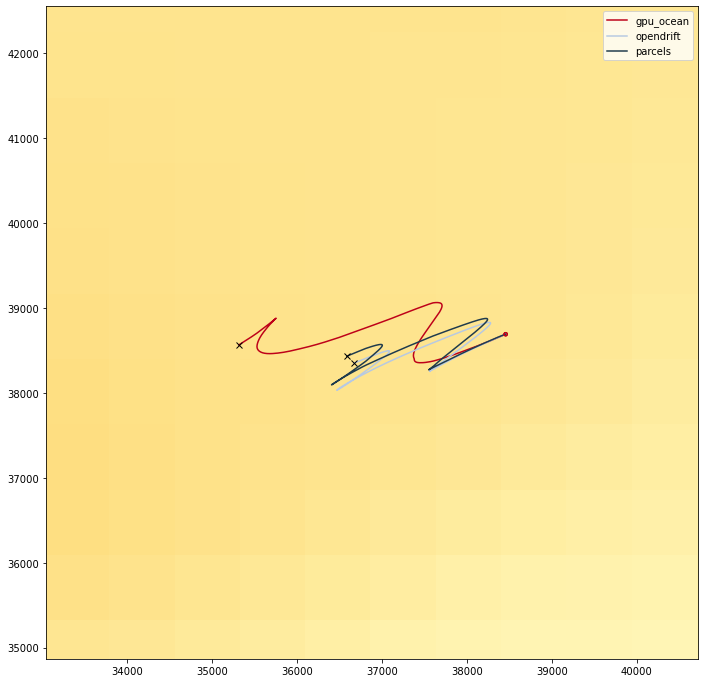

In [8]:
%matplotlib inline

#Create figure, ax with background
ax = createForecastCanvas(gpuocean_forecast,background = True, url= source_url, domain = domain, zoom = 10)

#Plot drifters
plotAllDrifters(gpuocean_forecast, ax= ax, color_id = 0, label = "gpu_ocean")
plotAllDrifters(opendrift_forecast_gpu, ax = ax, color_id = 1, label = "opendrift")
plotAllDrifters(parcels_forecast_gpu, ax = ax, color_id = 2, label = "parcels")
ax.legend()

### Another example

With and without wind in Opendrift and GPU Ocean + double resolution without wind in GPU Ocean:

In [9]:
opendrift_forecast_wind = simulate_opendrift(source_url, lat= lat, lon= lon, wind_drift_factor = 0.02) 
opendrift_forecast_wind_gpu = opendriftObj2gpuoceanObs(opendrift_forecast_wind, x0, x1, y0, y1)

gpuocean_forecast_wind = simulate_gpuocean_deterministic(source_url, domain, initx, inity, sim_args = sim_args, wind_drift_factor = 0.02)
gpuocean_forecast_double = simulate_gpuocean_deterministic(source_url, domain, initx, inity, sim_args = sim_args, rescale = 2)

  condition = (xf < v1) | (xf > v2)

  condition = (xf < v1) | (xf > v2)



'0% [##############################] 100%. Total: 36s, elapsed: 36s, remaining: 0s'

'0% [##############################] 100%. Total: 1m 10s, elapsed: 1m 10s, remaining: 0s'

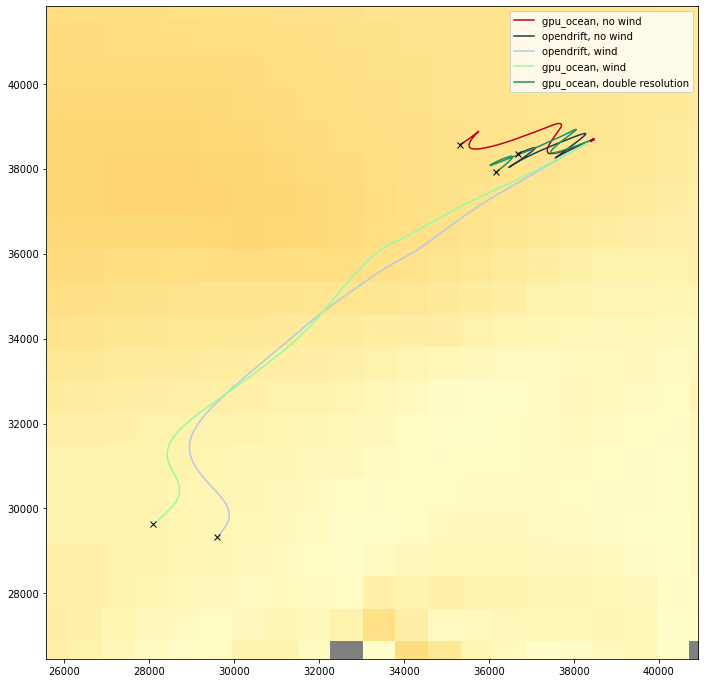

In [10]:
%matplotlib inline

#Create figure, ax with background
ax = createForecastCanvas(gpuocean_forecast_wind,background = True, url= source_url, domain = domain, zoom = 5)

#Plot drifters
plotAllDrifters(gpuocean_forecast, ax= ax, color_id = 0, label = "gpu_ocean, no wind")
plotAllDrifters(opendrift_forecast_gpu, ax = ax, color_id = 2, label = "opendrift, no wind")
plotAllDrifters(opendrift_forecast_wind_gpu, ax = ax, color_id = 1, label = "opendrift, wind")
plotAllDrifters(gpuocean_forecast_wind, ax= ax, color_id = 3, label = "gpu_ocean, wind")
plotAllDrifters(gpuocean_forecast_double, ax= ax, color_id = 4, label = "gpu_ocean, double resolution")
ax.legend()